# Extracellular electrophysiology analysis

NeuroNexus silicon probes electrodes were used for the extracellular electrophysiological recordings. 32 simultaneous recordings were obtained from the 8 shanks electrodes with 4 recording sites separated from each other by 100 µm (NeuroNexus A8x4-2mm-100-200-177). Silicon probes were connected to a pre-amplifier and signals were subsequently filtered and digitised with a Cereplex interface (Blackrock microsystem®) connected to a PC computer running the Central software suite (Blackrock microsystem®).

**Spike sorting** was done using Blackrock Offline Spike Sorting (BOSS) algorithm (Blackrock microsystem®). High Pass Filter allowed to select the signal with frequency higher than a cutoff frequency of 250 Hz. Using a single threshold value for different channels and different brain areas may cause misleading results and false positive spike detection. Therefore, thresholding was done automatically on all channels as a mean Root Mean Square (RMS) of the signal multiplied by -4.5 coefficient, which was previously reported to be a reasonable choice [Christie et al., 2015](https://pubmed.ncbi.nlm.nih.gov/25504690/). Detected waveforms were automatically classified using Principal Component Analysis (PCA) components 1, 2 and 3. PCA was reported to perform better as a feature extraction method compared to the basic characteristics of the spikes, such as amplitude or latency [Glaser et al., 1968](https://www.semanticscholar.org/paper/ON-LINE-SEPARATION-OF-INTERLEAVED-NEURONAL-PULSE-Glaser-Marks/1fcb09ed4f22844db0a3cd85f807f6a44e936439). Further classification based on PCA components was done by T distribution with penalty factor of 1. Resulting spikes were manually verified on all channels and corrected when necessary, based on the visual appearance of the spike shapes.

At this timepoint there were 2 files: **csv file** containing the timestamps of the spikes and **ns6 file** with raw unfiltered recording.

Analysis consists of the 7 discrete steps:

#### 1. Upload both files

#### 2. Compute auto or crosscorrelation

#### 3. Calculate Inter Spike Intervals (ISI)

#### 4. Compute an auto or cross correlogram
This was inspired by [Peyrache et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22307639/)

#### 5. Generate 1000 Artificial signals to check if your results on crosscorrelogram were significant

#### 6. Spike-triggered average local field potentials (STA-LFP)

#### 7. Autocorrelation on LFP

# 1. Files upload

There are 2 files: csv file outputed from BOSS and raw recording ns6 file

In [5]:
#Load the csv file containing the spike timestamps (after BOSS spike sorting)
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

channels_units = []

file = open('filename.csv')
file_data = csv.reader(file)
header = next(file_data)

#Re-arrange the data
for row in file_data:
  channels_units.append([row[0:2], row[2:]])

In [6]:
#Make a spike train of total ms length
#k = 1000 coefficient to make timescale in ms at 30000 sampling rate

def spike_trains_maker(times, k=1000):
  duration = 585 #total duration of recording in seconds
  spike_timestamps, spike_indices = [], []
  spike_train = np.zeros(int(duration * k))
  
  spike_timestamps = times[1]
  spike_indices = [int(spike_timestamps[i]) // 30 for i in range(len(spike_timestamps))]
  
  spike_train[spike_indices] = 1

  return(spike_train)

In [ ]:
#Open continuous recording file with Neo (ns6 format with raw recording)
from neo.io import BlackrockIO

filename = 'filename.ns6'
reader = BlackrockIO(filename)
segments = reader.read_block().segments

In [7]:
#Extract the microvolt values
for segment in segments:
    for analog_signal in segment.analogsignals:
        microvolts = analog_signal.magnitude

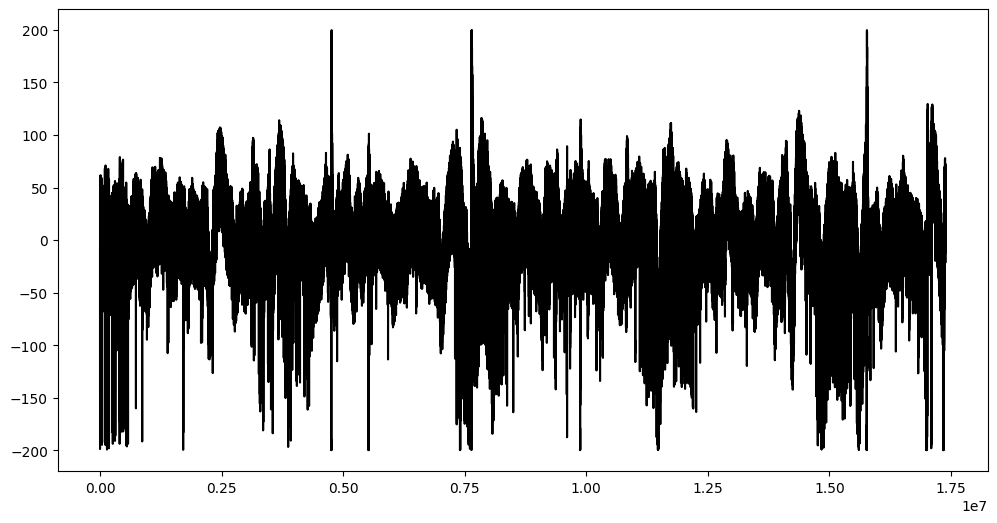

In [8]:
#Let's plot the raw recording of channel 24!
trace = []

for time in microvolts:
  if (time[23] < 200) and (time[23] > -200): #some noise filtering
    trace.append(time[23])

plt.figure(figsize=(12, 6))
plt.plot(trace, color="black")
plt.show()

# 2. Autocorrelation & Crosscorrelation

This method allows to measure the correlation between 2 input series (y and x) while accounting for the time lag (τ) between these [Dean et al., 2016](https://pubmed.ncbi.nlm.nih.gov/26100765/).

Spike was admitted to be produced by an isolated cell, if the corresponding autocorrelation plot contained at least 2 ms refractory period space around 0. Further analysis was focused on defining the cell type of the spike. Excitatory Regular Spiking (RS) and inhibitory Fast Spiking (FS) cells were previously separated based on spike waveform, duration, and firing rates [Peyrache et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22307639/). In the current internship a combination of autocorrelation analysis, spike shapes and Inter Spike Intervals (ISI) distribution was used to establish cell identity and if its activity was oscillatory.

To establish the relationships between 2 cells recorded by the same electrode, cross-correlation was calculated. If the cross-correlation was centred around 0 for all lags, cells fired independently from each other. The peak in positive values of lags, was indicating that changes in x series are associated with changes in future values y series, and vice versa.

In [9]:
#Correlate pair of spike trains
channel_x = channels_units[5]
channel_y = channels_units[5]
x = spike_trains_maker(channel_x)
y = spike_trains_maker(channel_y)

corr_result = sp.signal.correlate(x, y, mode='full')

#For autocorrelation to see the refractory period better, I get rid of the value at 0 lags
corr_result[int(len(corr_result)/2)] = 0

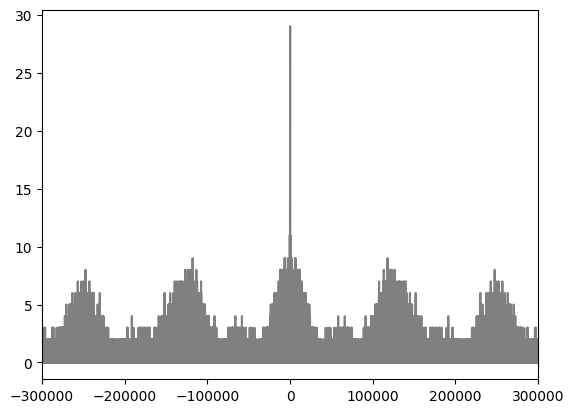

In [10]:
#Let's plot the autocorrelation
x_values = np.linspace(-len(corr_result)/2, len(corr_result)/2, len(corr_result))
x_values = np.round(x_values).astype(int)

plt.plot(x_values, corr_result, color="gray")
plt.xlim([-300000,300000])
plt.show()

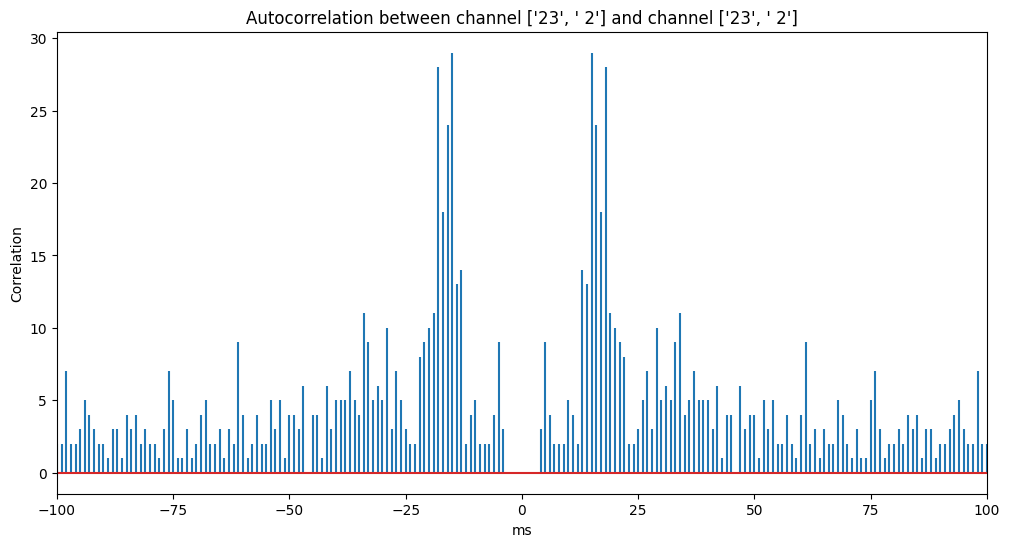

In [11]:
#Let's plot the results with other type of graph and magnification to see the refractory period
x_values = np.linspace(-len(corr_result)/2, len(corr_result)/2, len(corr_result))
x_values = np.round(x_values).astype(int)

plt.figure(figsize=(12, 6))
markerline, stemlines, baseline = plt.stem(
    x_values, corr_result, markerfmt='')
plt.xlabel('ms')
plt.xlim([-100, 100])
plt.ylabel('Correlation')
plt.title('Autocorrelation between channel '+str(channel_x[0])+ ' and channel '+str(channel_y[0]))
plt.show()

# 3. Inter Spike Intervals

In [12]:
#Finding Interspike intervals (ISI)
channel_of_interest, Timestamps_of_interest, ISI = [],[],[]

channel_of_interest = channels_units[5]

Timestamps_of_interest = channel_of_interest[1]

for i in range(len(Timestamps_of_interest)):
    Timestamps_of_interest[i] = int(Timestamps_of_interest[i]) / 30

ISI = [Timestamps_of_interest[i+1] - Timestamps_of_interest[i] for i in range(len(Timestamps_of_interest)-1)]

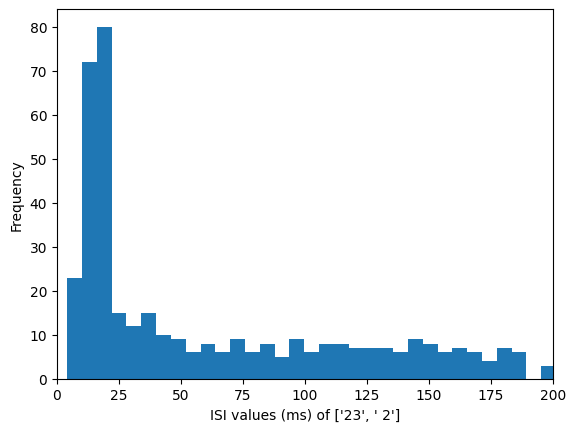

In [15]:
#Making a histogram of ISI distribution

#Calculate average of values between 0 and 10 and make it a bin size
bin_size = np.mean([x for x in ISI if 0 <= x <= 10])

plt.hist(ISI, bins=np.arange(min(ISI), max(ISI) + bin_size, bin_size))
plt.xlabel('ISI values (ms) of '+str(channel_of_interest[0]))
plt.ylabel('Frequency')
plt.xlim(0, 200)
plt.show()

In [16]:
#Let's calculate mean ISI while removing the outliers
import statistics
def remove_outliers_and_calculate_mean(data):
    #Calculate mean and standard deviation
    mean = statistics.mean(data)
    standard_deviation = statistics.stdev(data)

    #Remove outliers
    modified_data = [x for x in data if (mean - 2 * standard_deviation) < x < (mean + 2 * standard_deviation)]

    #Calculate mean of modified data
    modified_mean = statistics.mean(modified_data)

    return modified_mean

print(remove_outliers_and_calculate_mean(ISI))

340.9980607966459


# 4. Correlogram (based on train A spikes)

Correlograms were calculated on the spike trains to find the cumulative number of spikes in x happening at the timestamps of the spikes in y within the 50 ms window around each spike. This allowed to conclude upon inhibitory and excitatory relationships between 2 cells. For each cell 1,000 artificial spike trains were created, maintaining the length of the train, number of spikes and ISI, and the expected mean cross-correlogram with 95% Confidence Interval (CI) was estimated. All activity exceeding the upper boundary or preceding the lower boundary of the CI was considered remarkable.

In [17]:
#Make spike trains for 2 channels of interest
channel_a = channels_units[5]
channel_b = channels_units[5]
a = spike_trains_maker(channel_a)
b = spike_trains_maker(channel_b)

spike_distribution_b = np.zeros(51)

for spike_time in np.nonzero(a)[0]:
    window_start = spike_time - 25
    window_end = spike_time + 26

    for k in range(window_start, window_end):
      if b[k] == 1:
        spike_distribution_b[k-window_start]+=1
      else:
        continue

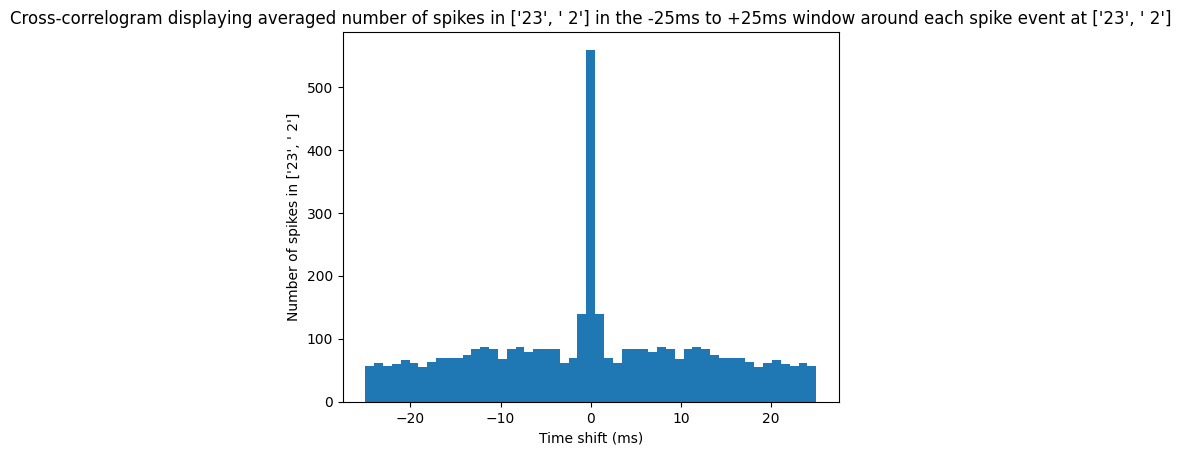

In [18]:
#Make a histogram of average distribution of spikes in b around the spike event in a within -25, +25 ms range
x_values = range(-25, 26)
plt.hist(x_values, bins=len(x_values), weights=spike_distribution_b)
plt.xlabel('Time shift (ms)')
plt.ylabel('Number of spikes in '+str(channel_b[0]))
plt.title('Cross-correlogram displaying averaged number of spikes in '+str(channel_b[0])+ ' in the -25ms to +25ms window around each spike event at '+str(channel_a[0]))
plt.show()

# 5. Artificial Signal Generation for correlogram stats

The idea was to generate artificial spike trains of the same length, with the same number of spikes and same ISI

In [19]:
import random

#What channel will be used as spike source?
channel_a = channels_units[5]
a = spike_trains_maker(channel_a)

#Define the signal based on which you want to make artificial signals
art_chan = channels_units[5]
art = spike_trains_maker(art_chan)

In [20]:
def art_trains_generator(art=art):
  #Find the positions of the 1s
  one_indices = [i for i, x in enumerate(art) if x == 1]
  
  #Calculate the intervals between the 1s
  intervals = [one_indices[i+1] - one_indices[i] - 1 for i in range(len(one_indices)-1)]
  intervals.append(len(art) - one_indices[-1] - 1)
  
  #Shuffle the intervals
  random.shuffle(intervals)
  
  #Build the shuffled list
  shuffled_art = []
  start_index = 0
  for interval in intervals:
    #Add the 1
    shuffled_art.append(1)
    #Add the 0s
    shuffled_art.extend([0] * interval)
    #Update the start index for the next segment
    start_index += interval + 1
    
  #Add the last segment of 0s (if any)
  if start_index < len(art):
    shuffled_art.extend([0] * (len(art) - start_index))

  return(shuffled_art)

In [21]:
list_of_art_spike_distributions = []

for i in range(0,1000):
  
  b = art_trains_generator(art)
  spike_distribution_b = np.zeros(51)

  for spike_time in np.nonzero(a)[0]:
    window_start = spike_time - 25
    window_end = spike_time + 26
    
    for k in range(window_start, window_end):
      if b[k] == 1:
        spike_distribution_b[k-window_start]+=1
      else:
        continue

  list_of_art_spike_distributions.append(spike_distribution_b)

In [22]:
#Calculate the mean list
mean_list_of_art_spike_distributions = np.mean(list_of_art_spike_distributions, axis=0)

#Calculate the standard error of the mean
sem = np.std(list_of_art_spike_distributions, axis=0) / np.sqrt(len(list_of_art_spike_distributions))

#Calculate the margin of error (95% confidence interval)
margin_of_error = 1.96 * sem

#Calculate the lower and upper boundaries of the confidence interval
lower_boundary_art = mean_list_of_art_spike_distributions - margin_of_error
upper_boundary_art = mean_list_of_art_spike_distributions + margin_of_error

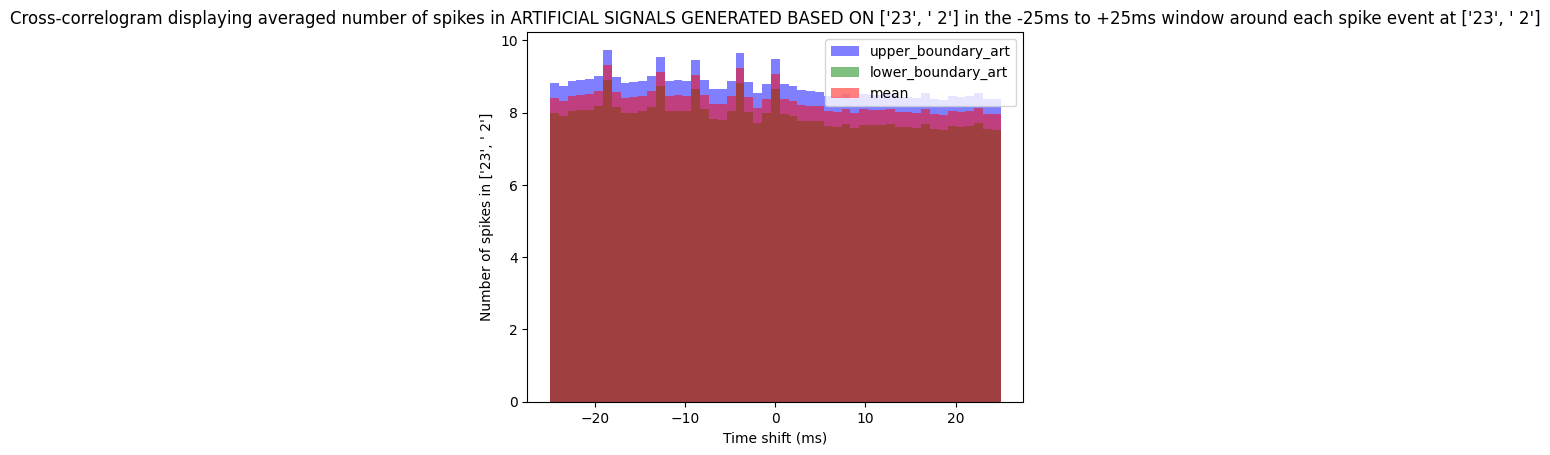

In [23]:
#Make a histogram of average distribution of spikes in b around the spike event in a within -25,+25 ms range
x_values = range(-25, 26)
colors = ['blue', 'green', 'red']

plt.hist(x_values, bins=len(x_values), weights=upper_boundary_art, color=colors[0], alpha=0.5, label='upper_boundary_art')
plt.hist(x_values, bins=len(x_values), weights=lower_boundary_art, color=colors[1], alpha=0.5, label='lower_boundary_art')
plt.hist(x_values, bins=len(x_values), weights=mean_list_of_art_spike_distributions, color=colors[2], alpha=0.5, label='mean')

plt.xlabel('Time shift (ms)')
plt.ylabel('Number of spikes in '+str(art_chan[0]))
plt.title('Cross-correlogram displaying averaged number of spikes in ARTIFICIAL SIGNALS GENERATED BASED ON '+str(art_chan[0])+ ' in the -25ms to +25ms window around each spike event at '+str(channel_a[0]))
plt.legend()
plt.show()

# 6. STA-LFP

Cross STA-LFP was another used measure of directionality of signals recorded in the cells.
It shows the values (e.g. positive/negative voltage values) of the LFP preceding or following the time of the spike generation

In [24]:
#Extract microvolt values for specific channel necessary
necessary_channel = 23 #give the number by 1 less than number of channel
trace = []

for time in microvolts:
  trace.append(time[necessary_channel])

In [25]:
#Make spike train for the channel chosen previously
channel_n = channels_units[5]
n = spike_trains_maker(channel_n, k=30000)

microvolt_distribution_n = np.zeros(1530)

#Find an average microvolt distribution in the LFP of the same channel -25 ms to 25 ms around the spike event
for spike_time in np.nonzero(n)[0]:
    window_start = spike_time - 750
    window_end = spike_time + 780

    for k in range(window_start, window_end):
      microvolt_distribution_n[k-window_start]+=trace[k]

microvolt_distribution_n = [uV / len(np.nonzero(n)[0]) for uV in microvolt_distribution_n]

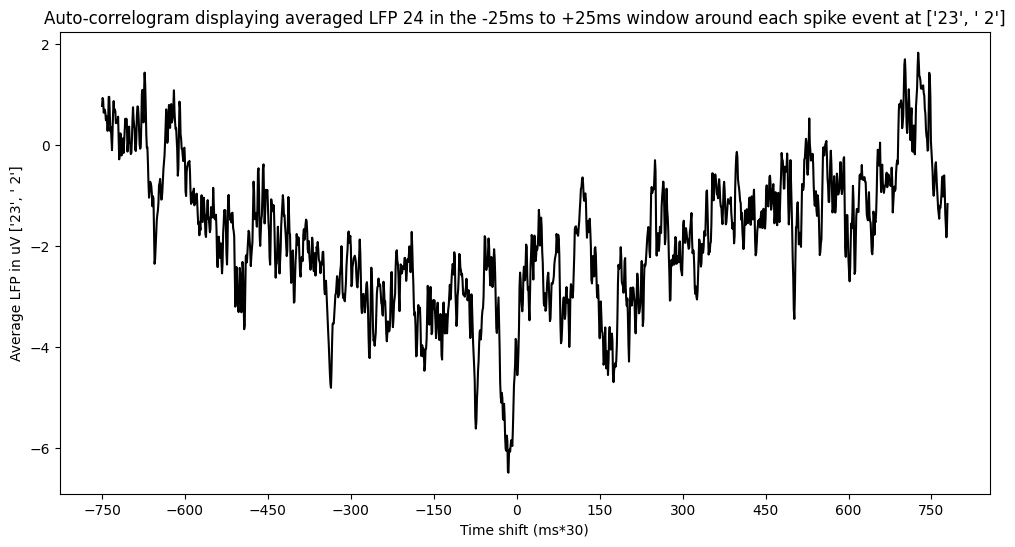

In [26]:
#Make a histogram of average distribution of LFP around the spike event in a within -25,+25 ms range
x_values = range(-750, 780)
plt.figure(figsize=(12, 6))
plt.plot(x_values, microvolt_distribution_n, color="black")
plt.xlabel('Time shift (ms*30)')
plt.ylabel('Average LFP in uV '+str(channel_n[0]))
plt.title('Auto-correlogram displaying averaged LFP '+str(necessary_channel+1)+ ' in the -25ms to +25ms window around each spike event at '+str(channel_n[0]))
new_tick_locations = np.arange(-750, 781, 150)
plt.xticks(new_tick_locations)
plt.show()

# 7. Autocorrelation on LFP

Should be usefull to see oscillatory behaviour of the cell

In [27]:
x = trace

#Resize the array to 120000 elements using numpy's resize() function
downsampled_x = np.resize(x, (120000,))

In [28]:
corr_result_LFP = sp.signal.correlate(downsampled_x, downsampled_x, mode='full')

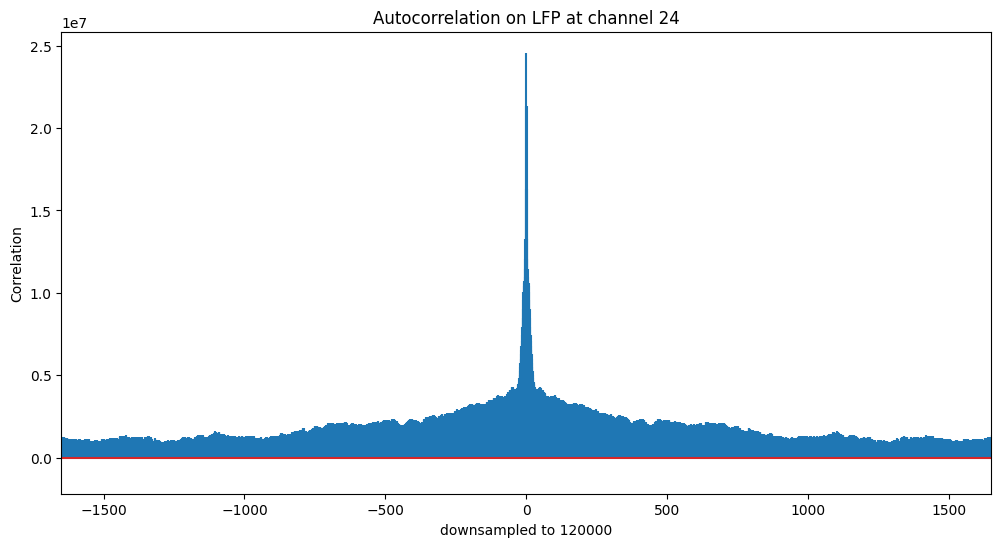

In [30]:
#Plot the results
x_values = np.linspace(-len(corr_result_LFP)/2, len(corr_result_LFP)/2, len(corr_result_LFP))
x_values = np.round(x_values).astype(int)

plt.figure(figsize=(12, 6))
markerline, stemlines, baseline = plt.stem(
    x_values, corr_result_LFP, markerfmt='', bottom=0.0)
plt.xlabel('downsampled to 120000')
plt.xlim([-1650, 1650])
plt.ylabel('Correlation')
plt.title('Autocorrelation on LFP at channel '+str(necessary_channel+1))
plt.show()